<a href="https://colab.research.google.com/github/somaSystems/ImageTranslator/blob/main/final_used_ld_test_cellpose_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook explains processing example 2D and 3D images using the Cellpose package on Google Colab using the GPU.

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

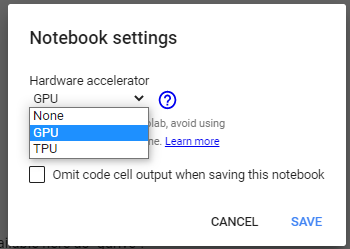

### Install Cellpose-SAM

In [ ]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-7ky7dgub
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-7ky7dgub
  Resolved https://www.github.com/mouseland/cellpose.git to commit 8ef88040d9aec85737e12c3f2c2969ecf149f7f0
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   

Check GPU and instantiate model - will download weights.

In [ ]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.5.dev27+g8ef8804 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


creating new log file
2025-06-25 15:54:00,706 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-06-25 15:54:00,710 [INFO] 
cellpose version: 	4.0.5.dev27+g8ef8804 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-06-25 15:54:00,989 [INFO] ** TORCH CUDA version installed and working. **
2025-06-25 15:54:00,991 [INFO] ** TORCH CUDA version installed and working. **
2025-06-25 15:54:00,991 [INFO] >>>> using GPU (CUDA)
2025-06-25 15:54:04,732 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:11<00:00, 107MB/s]


### Download example images

100%|██████████| 21.3M/21.3M [00:03<00:00, 6.82MB/s]
100%|██████████| 1.63M/1.63M [00:01<00:00, 1.13MB/s]


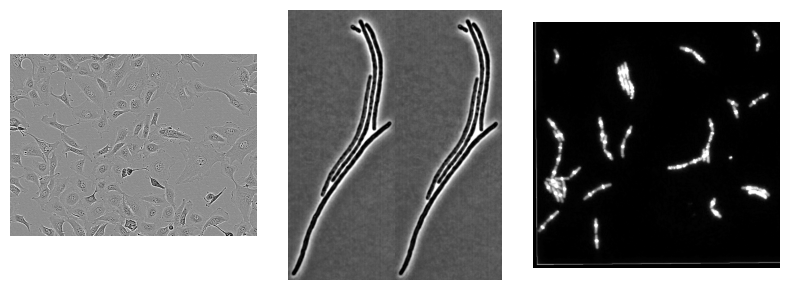

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import utils, io

# download example 2D images from website
url = "http://www.cellpose.org/static/data/imgs_cyto3.npz"
filename = "imgs_cyto3.npz"
utils.download_url_to_file(url, filename)

# download 3D tiff
url = "http://www.cellpose.org/static/data/rgb_3D.tif"
utils.download_url_to_file(url, "rgb_3D.tif")

dat = np.load(filename, allow_pickle=True)["arr_0"].item()

imgs = dat["imgs"]
masks_true = dat["masks_true"]

plt.figure(figsize=(8,3))
for i, iex in enumerate([9, 16, 21]):
    img = imgs[iex].squeeze()
    plt.subplot(1,3,1+i)
    plt.imshow(img[0], cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Run Cellpose-SAM

In [ ]:
masks_pred, flows, styles = model.eval(imgs, niter=1000) # using more iterations for bacteria


2025-06-25 15:57:53,608 [INFO] 100%|##########| 24/24 [01:57<00:00,  4.88s/it]


plot results

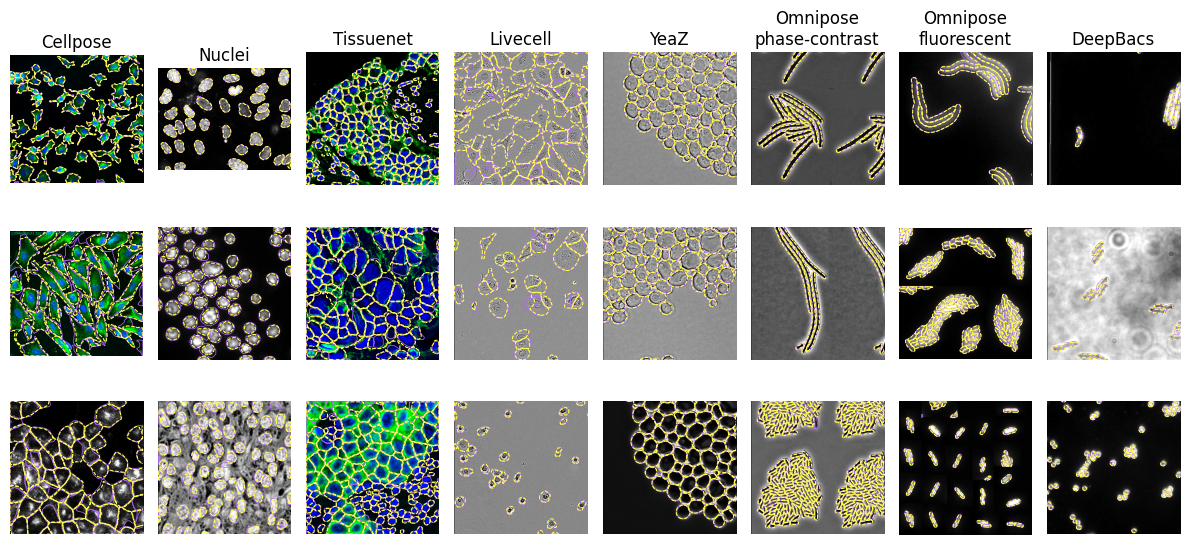

In [ ]:
from cellpose import transforms, plot

titles = [
        "Cellpose", "Nuclei", "Tissuenet", "Livecell", "YeaZ",
         "Omnipose\nphase-contrast", "Omnipose\nfluorescent",
        "DeepBacs"
    ]

plt.figure(figsize=(12,6))
ly = 400
for iex in range(len(imgs)):
    img = imgs[iex].squeeze().copy()
    img = np.clip(transforms.normalize_img(img, axis=0), 0, 1) # normalize images across channel axis
    ax = plt.subplot(3, 8, (iex%3)*8 + (iex//3) +1)
    if img[1].sum()==0:
        img = img[0]
        ax.imshow(img, cmap="gray")
    else:
        # make RGB from 2 channel image
        img = np.concatenate((np.zeros_like(img)[:1], img), axis=0).transpose(1,2,0)
        ax.imshow(img)
    ax.set_ylim([0, min(400, img.shape[0])])
    ax.set_xlim([0, min(400, img.shape[1])])


    # GROUND-TRUTH = PURPLE
    # PREDICTED = YELLOW
    outlines_gt = utils.outlines_list(masks_true[iex])
    outlines_pred = utils.outlines_list(masks_pred[iex])
    for o in outlines_gt:
        plt.plot(o[:,0], o[:,1], color=[0.7,0.4,1], lw=0.5)
    for o in outlines_pred:
        plt.plot(o[:,0], o[:,1], color=[1,1,0.3], lw=0.75, ls="--")
    plt.axis('off')

    if iex%3 == 0:
        ax.set_title(titles[iex//3])

plt.tight_layout()
plt.show()

# Run Cellpose-SAM in 3D

There are two ways to run cellpose in 3D, this cell shows both, choose which one works best for you.

First way: computes flows from 2D slices and combines into 3D flows to create masks



In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
from skimage import io
# img_3D = io.imread('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/ ')
img_3D = io.imread('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/filtedownsize_r2_sbtbck_100_C2_only_cell1_t1z45_CRY2_CellTracker_BF-1-3.tif ')

In [ ]:
print(f"Image shape: {img_3D.shape}")
print(f"Image dtype: {img_3D.dtype}")
print(f"Image min/max values: {img_3D.min()} / {img_3D.max()}")

In [ ]:
# img_3D = io.imread("rgb_3D.tif")


# 1. computes flows from 2D slices and combines into 3D flows to create masks
masks, flows, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                batch_size=32,
                                do_3D=True, flow3D_smooth=1)

import tifffile
import os

# Get original filename without extension
original_name = os.path.splitext(os.path.basename('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/rgb_3D.tif'))[0]

# Save 3D results with original filename
tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/masks_3D_{original_name}.tif',
                 masks.astype('uint16'))
tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/flows_3D_{original_name}.tif',
                 flows[0])
print(f"✅ Saved 3D results for {original_name}")

2025-06-25 16:28:44,815 [INFO] running YX: 45 planes of size (226, 225)
2025-06-25 16:29:00,139 [INFO] 100%|##########| 2/2 [00:15<00:00,  7.66s/it]
2025-06-25 16:29:00,198 [INFO] running ZY: 226 planes of size (45, 225)
2025-06-25 16:30:13,907 [INFO] 100%|##########| 8/8 [01:13<00:00,  9.21s/it]
2025-06-25 16:30:13,936 [INFO] running ZX: 225 planes of size (45, 226)
2025-06-25 16:31:27,468 [INFO] 100%|##########| 8/8 [01:13<00:00,  9.19s/it]
2025-06-25 16:31:27,542 [INFO] network run in 162.73s
2025-06-25 16:31:27,543 [INFO] smoothing flows with sigma=1
2025-06-25 16:31:28,810 [INFO] masks created in 0.31s


In [ ]:
# import tifffile

# # Save 3D flow results
# tifffile.imwrite('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/masks_3D.tif',
#                  masks.astype('uint16'))
# tifffile.imwrite('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/flows_3D.tif',
#                  flows[0])

# print("✅ Saved 3D masks and flows to Google Drive")

✅ Saved 3D masks and flows to Google Drive


In [ ]:
# import tifffile

# # Save stitched results
# tifffile.imwrite('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/masks_stitched.tif',
#                  masks_stitched.astype('uint16'))
# tifffile.imwrite('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/flows_stitched.tif',
#                  flows_stitched[0])

# print("✅ Saved stitched masks and flows to Google Drive")

✅ Saved stitched masks and flows to Google Drive


Second way: computes masks in 2D slices and stitches masks in 3D based on mask overlap

Note stitching (with stitch_threshold > 0) can also be used to track cells over time.

In [ ]:
# 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
print('running cellpose 2D + stitching masks')
masks_stitched, flows_stitched, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                                  batch_size=32,
                                                  do_3D=False, stitch_threshold=0.5)

import tifffile
import os

# Get original filename without extension
original_name = os.path.splitext(os.path.basename('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/rgb_3D.tif'))[0]

# Save stitched results with original filename
tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/masks_stitched_{original_name}.tif',
                 masks_stitched.astype('uint16'))
tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/flows_stitched_{original_name}.tif',
                 flows_stitched[0])
print(f"✅ Saved stitched results for {original_name}")

running cellpose 2D + stitching masks
2025-06-25 16:31:50,849 [INFO] 100%|##########| 2/2 [00:14<00:00,  7.36s/it]
2025-06-25 16:31:50,850 [INFO] network run in 14.72s
2025-06-25 16:31:50,886 [INFO] 0%|          | 0/45 [00:00<?, ?it/s]
2025-06-25 16:31:55,433 [INFO] No cell pixels found.
2025-06-25 16:31:55,435 [INFO] No cell pixels found.
2025-06-25 16:31:55,436 [INFO] No cell pixels found.
2025-06-25 16:31:55,437 [INFO] 100%|##########| 45/45 [00:04<00:00,  9.89it/s]
2025-06-25 16:31:55,437 [INFO] stitching 45 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 44/44 [00:00<00:00, 523.08it/s]

2025-06-25 16:31:55,596 [INFO] masks created in 4.71s


In [ ]:
# import tifffile

# # Save masks
# tifffile.imwrite('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/masks_stitched.tif',
#                 masks_stitched.astype('uint16'))

# # Save flows (optional)
# tifffile.imwrite('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/flows_stitched.tif',
#                 flows_stitched[0])

Results from 3D flows => masks computation

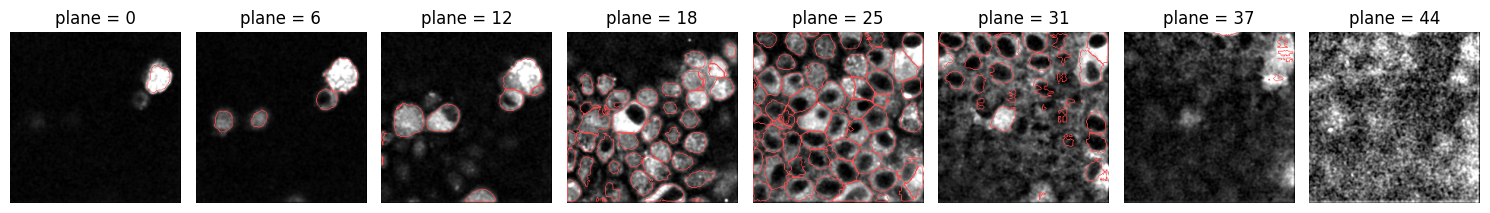

In [ ]:
# DISPLAY RESULTS 3D flows => masks (auto-adapts to image dimensions and channels)
plt.figure(figsize=(15,3))

# Get actual image dimensions
z_max = img_3D.shape[0]
num_planes = 8
plane_indices = np.linspace(0, z_max-1, num_planes, dtype=int)

# Check number of channels
if len(img_3D.shape) == 4:  # Has channel dimension
   n_channels = img_3D.shape[1]
else:  # No channel dimension
   n_channels = 1

for i, iplane in enumerate(plane_indices):
   # Handle different channel configurations
   if n_channels == 1:
       if len(img_3D.shape) == 4:
           img0 = plot.image_to_rgb(img_3D[iplane, 0].copy())
       else:
           img0 = plot.image_to_rgb(img_3D[iplane].copy())
   elif n_channels >= 2:
       img0 = plot.image_to_rgb(img_3D[iplane, [min(1, n_channels-1), 0]].copy(), channels=[2,3])

   plt.subplot(1, num_planes, i+1)
   outlines = utils.masks_to_outlines(masks[iplane])
   outX, outY = np.nonzero(outlines)
   imgout = img0.copy()
   imgout[outX, outY] = np.array([255,75,75])
   plt.imshow(imgout)
   plt.title('plane = %d'%iplane)
   plt.axis('off')

plt.tight_layout()
plt.show()

Results from stitching

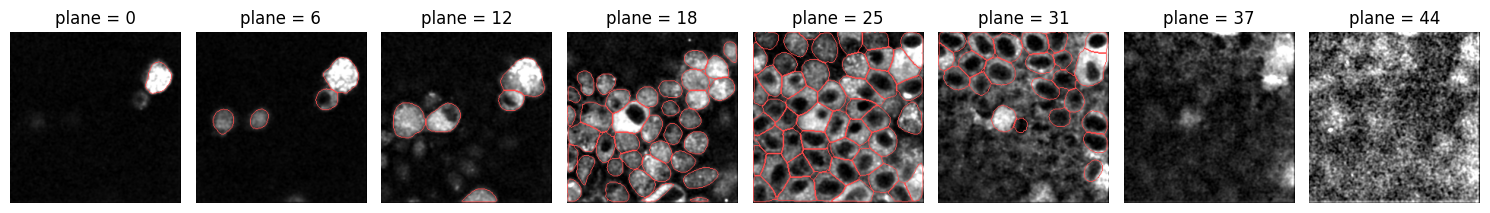

In [ ]:
# DISPLAY RESULTS stitching (auto-adapts to image dimensions and channels)
plt.figure(figsize=(15,3))

# Get actual image dimensions
z_max = img_3D.shape[0]
num_planes = 8
plane_indices = np.linspace(0, z_max-1, num_planes, dtype=int)

# Check number of channels
if len(img_3D.shape) == 4:  # Has channel dimension
   n_channels = img_3D.shape[1]
else:  # No channel dimension
   n_channels = 1

for i, iplane in enumerate(plane_indices):
   # Handle different channel configurations
   if n_channels == 1:
       if len(img_3D.shape) == 4:
           img0 = plot.image_to_rgb(img_3D[iplane, 0].copy())
       else:
           img0 = plot.image_to_rgb(img_3D[iplane].copy())
   elif n_channels >= 2:
       img0 = plot.image_to_rgb(img_3D[iplane, [min(1, n_channels-1), 0]].copy(), channels=[2,3])

   plt.subplot(1, num_planes, i+1)
   outlines = utils.masks_to_outlines(masks_stitched[iplane])
   outX, outY = np.nonzero(outlines)
   imgout = img0.copy()
   imgout[outX, outY] = np.array([255,75,75])
   plt.imshow(imgout)
   plt.title('plane = %d'%iplane)
   plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from skimage import io
# img_3D = io.imread('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/ ')
img_3D = io.imread('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/t1_ITB1cell3.oif - Series 1-1.tif')

In [ ]:
# img_3D = io.imread("rgb_3D.tif")


# 1. computes flows from 2D slices and combines into 3D flows to create masks
masks, flows, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                batch_size=32,
                                do_3D=True, flow3D_smooth=1)

import tifffile
import os

# # Get original filename without extension
# original_name = os.path.splitext(os.path.basename('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/rgb_3D.tif'))[0]

# # Save 3D results with original filename
# tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/masks_3D_{original_name}.tif',
#                  masks.astype('uint16'))
# tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/flows_3D_{original_name}.tif',
#                  flows[0])
# print(f"✅ Saved 3D results for {original_name}")
import tifffile
import os

# Get original filename from the imread path
input_path = '/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/t1_ITB1cell3.oif - Series 1-1.tif'
original_name = os.path.splitext(os.path.basename(input_path))[0]

# Save 3D results with original filename
tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/masks_3D_{original_name}.tif',
                 masks.astype('uint16'))
tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/flows_3D_{original_name}.tif',
                 flows[0])
print(f"✅ Saved 3D results for {original_name}")

2025-06-25 17:27:21,907 [INFO] running YX: 60 planes of size (452, 450)
2025-06-25 17:30:19,456 [INFO] 100%|##########| 20/20 [02:57<00:00,  8.88s/it]
2025-06-25 17:30:19,731 [INFO] running ZY: 452 planes of size (60, 450)
2025-06-25 17:37:41,521 [INFO] 100%|##########| 46/46 [07:21<00:00,  9.60s/it]
2025-06-25 17:37:41,698 [INFO] running ZX: 450 planes of size (60, 452)
2025-06-25 17:45:01,661 [INFO] 100%|##########| 45/45 [07:19<00:00,  9.78s/it]
2025-06-25 17:45:02,051 [INFO] network run in 1060.14s
2025-06-25 17:45:02,053 [INFO] smoothing flows with sigma=1
2025-06-25 17:45:05,617 [INFO] masks created in 1.31s
✅ Saved 3D results for rgb_3D


In [ ]:
# 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
print('running cellpose 2D + stitching masks')
masks_stitched, flows_stitched, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                                  batch_size=32,
                                                  do_3D=False, stitch_threshold=0.5)

# import tifffile
# import os

# # Get original filename without extension
# original_name = os.path.splitext(os.path.basename('/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/rgb_3D.tif'))[0]

# # Save stitched results with original filename
# tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/masks_stitched_{original_name}.tif',
#                  masks_stitched.astype('uint16'))
# tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/flows_stitched_{original_name}.tif',
#                  flows_stitched[0])
# print(f"✅ Saved stitched results for {original_name}")

import tifffile
import os

# Get original filename from the imread path
input_path = '/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/t1_ITB1cell3.oif - Series 1-1.tif'
original_name = os.path.splitext(os.path.basename(input_path))[0]

# Save stitched results with original filename
tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/masks_stitched_{original_name}.tif',
                 masks_stitched.astype('uint16'))
tifffile.imwrite(f'/content/drive/MyDrive/MP_Epithelia_2025/cellposeSAM_mount_LD/flows_stitched_{original_name}.tif',
                 flows_stitched[0])
print(f"✅ Saved stitched results for {original_name}")

running cellpose 2D + stitching masks
2025-06-25 17:56:03,472 [INFO] 100%|##########| 20/20 [02:57<00:00,  8.89s/it]
2025-06-25 17:56:03,473 [INFO] network run in 177.71s
2025-06-25 17:56:03,780 [INFO] 0%|          | 0/60 [00:00<?, ?it/s]
2025-06-25 17:56:03,782 [INFO] No cell pixels found.
2025-06-25 17:56:12,031 [INFO] No cell pixels found.
2025-06-25 17:56:12,175 [INFO] No cell pixels found.
2025-06-25 17:56:12,180 [INFO] No cell pixels found.
2025-06-25 17:56:12,184 [INFO] No cell pixels found.
2025-06-25 17:56:12,504 [INFO] No cell pixels found.
2025-06-25 17:56:12,508 [INFO] No cell pixels found.
2025-06-25 17:56:12,512 [INFO] No cell pixels found.
2025-06-25 17:56:12,514 [INFO] No cell pixels found.
2025-06-25 17:56:12,518 [INFO] No cell pixels found.
2025-06-25 17:56:12,721 [INFO] No cell pixels found.
2025-06-25 17:56:12,725 [INFO] No cell pixels found.
2025-06-25 17:56:13,004 [INFO] No cell pixels found.
2025-06-25 17:56:13,006 [INFO] No cell pixels found.
2025-06-25 17:56:13

100%|██████████| 59/59 [00:00<00:00, 223.53it/s]


2025-06-25 17:56:13,927 [INFO] masks created in 10.15s
✅ Saved stitched results for t1_ITB1cell3.oif - Series 1-1
